In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
pd.options.mode.chained_assignment = None  
from scipy import optimize,interpolate
import sklearn 
from sklearn.cluster import DBSCAN
import scipy
from lmfit import Model
from mpl_point_clicker import clicker

/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [2]:
%matplotlib widget

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.spatial.transform import Rotation
from sympy import Matrix, pi, pprint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class TNG50DataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.chunk_size = 102609 // 9
        self.load_data()

    def load_data(self):
        chunks = pd.read_csv(self.file_path, sep=',', names=['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho'], header=0, chunksize=self.chunk_size)
        self.accumulated_data = np.concatenate([chunk.values for chunk in chunks])

    def calculate_center_of_mass_new(self, value_energy=2.63):
        Log_energy = np.log10(self.accumulated_data[:, 10])
        avg_energy = np.mean(Log_energy)
        if value_energy == 1:
            value_energy = avg_energy
        energy_filter = Log_energy < value_energy
        self.filtered_data = self.accumulated_data[energy_filter]
        return np.sum(self.filtered_data[:, :3], axis=0) / len(self.accumulated_data)

    def calculate_total_angular_momentum(self):
        center_of_mass = self.calculate_center_of_mass_new()
        r_i = self.filtered_data[:, :3] - center_of_mass
        v_i = self.filtered_data[:, 3:6] - self.calculate_velocity_of_mass()
        return np.sum(np.cross(r_i, v_i), axis=0)

    def calculate_velocity_of_mass(self):
        return np.mean(self.filtered_data[:, 3:6], axis=0)

class RotationHandler:
    def __init__(self, direction):
      self.direction = direction
      direction = angular_direction[largest_component]
      pass

    def choose_rotation_matrix(self, largest_component, direction):
        if largest_component == 0:
            if direction == 1:
                matrix = Rotation.from_euler('y', -pi/2).as_matrix()
            elif direction == -1:
                matrix = Rotation.from_euler('y', pi/2).as_matrix()
        elif largest_component == 1:
            if direction == 1:
                matrix = Rotation.from_euler('x', pi/2).as_matrix()
            elif direction == -1:
                matrix = Rotation.from_euler('x', -pi/2).as_matrix()
        elif largest_component == 2:
            if direction == 1:
                matrix = np.identity(3)
            elif direction == -1:
                matrix = Rotation.from_euler('z', pi).as_matrix()
        return matrix

    def apply_rotation(self, matrix, vector):
        rotated_array = np.zeros_like(vector)
        if vector.size == 3:
            rotated_array = np.dot(matrix, vector)
        else:
            for i in range(vector.shape[0]):
                rotated_array[i, :] = np.dot(matrix, vector[i, :])
        return rotated_array

class VelocityEscapeCalculator:
    def __init__(self, data, potential):
        self.data = data
        self.potential = potential

    def calculate_magnitudes(self):
        velocity_magnitude = np.sqrt(np.sum(self.data[:, 3:6]**2, axis=1)).reshape(-1, 1)
        position_magnitude = np.sqrt(np.sum(self.data[:, :3]**2, axis=1)).reshape(-1, 1)
        self.data = np.concatenate([self.data, velocity_magnitude, position_magnitude], axis=1)

    def calculate_escape_velocity(self):
        escape_velocity = np.sqrt(2 * np.abs(self.potential)).reshape(-1, 1)
        self.data = np.concatenate([self.data, escape_velocity], axis=1)

    def get_processed_data(self):
        columns = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho', 'velocity_magnitude', 'position_magnitude', 'escape_velocity']
        return pd.DataFrame(self.data, columns=columns)

class VisualizationHandler:
    def visualize_galaxy_one(self, rotated_vectors_filtered, center_of_mass, ax, title):
        ax.scatter(rotated_vectors_filtered[:, 0], rotated_vectors_filtered[:, 1], s=0.003, alpha=0.5)
        ax.scatter(center_of_mass[0], center_of_mass[1], color='red', s=0.3, marker='x')
        ax.set_title(title)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(-18, 18)
        ax.set_ylim(-18, 18)
        ax.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.axvline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.grid(True, alpha=0.4)


In [4]:
%matplotlib widget


In [5]:
id='368843'
simulation = TNG50DataProcessor(f"DATA/processed/halo_{id}_datos_dbscan_sf.csv")
data = simulation.accumulated_data
data

array([[ 9.75911088e-01,  2.32533694e+00, -1.74169474e+00, ...,
        -5.24519750e+05,  2.56156403e+02,  1.71000000e-04],
       [ 9.66984765e-01,  2.36436203e+00, -2.04409799e+00, ...,
        -5.18548062e+05,  1.59294724e+02,  1.62000000e-04],
       [ 5.92225515e-01,  2.63288096e+00, -1.60799287e+00, ...,
        -5.24748062e+05,  1.99209747e+02,  2.24000000e-04],
       ...,
       [ 9.19907419e+00,  6.72487778e+01, -1.42489294e+02, ...,
        -1.66366312e+05,  2.68354034e+02,  7.00000000e-06],
       [ 1.07519594e+01,  6.82124122e+01, -1.41100277e+02, ...,
        -1.66848609e+05,  2.80796021e+02,  7.00000000e-06],
       [ 1.17496913e+01,  6.98375034e+01, -1.40391450e+02, ...,
        -1.66890906e+05,  2.63283875e+02,  9.00000000e-06]])

# **Arm Tracing $\rho$**

In [46]:
# Crear un DataFrame con las columnas necesarias
df = pd.DataFrame(data, columns=['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential', 'U', 'rho'])

# Convertir coordenadas a coordenadas galácticas (Rs y Zs) si es necesario
df['Rs'] = np.sqrt(df['x']**2 + df['y']**2)  # Ejemplo de cómo obtener Rs
df['Zs'] = df['z']

# Filtrar el disco galáctico, similar a lo que se hace en el notebook original
Initial_df_sorted = df.sort_values(by=['Rs'])

df_filtered = df[(np.abs(Initial_df_sorted['Zs']) <= 1.5) & (Initial_df_sorted['Rs'] > 0.69)]



Xs_i       = Initial_df_sorted['x']
Ys_i       = Initial_df_sorted['y']
Rs_i       = Initial_df_sorted['Rs']

rho_sph_i       = Initial_df_sorted['rho']

Xs_z       = df_filtered["x"]
Ys_z       = df_filtered["y"]
Rs_z       = df_filtered["Rs"]

rho_sph_z       = df_filtered["rho"]

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


In [73]:
Rs_mean  = []
rho_sph_mean = []
deltaR  = 0.1
step    = 0
while(step + deltaR < 96):
    a = np.mean(rho_sph_z[(Rs_z > step ) & (Rs_z < step + deltaR) ] )
    minBin = np.min(Rs_z[ (Rs_z > step ) & (Rs_z < step + deltaR) ] )    
    maxBin = np.max(Rs_z[ (Rs_z > step ) & (Rs_z < step + deltaR) ] ) 

    b = np.round( (maxBin + minBin)*0.5, 2)
    rho_sph_mean.append(a)
    Rs_mean.append(b)
    step = step + 0.1

    
Rs_mean = [x for x in Rs_mean if str(x) != 'nan']
rho_sph_mean = [x for x in rho_sph_mean if str(x) != 'nan']

In [74]:
x = np.array(Rs_mean)
y = np.array(rho_sph_mean)

ylog = np.array( np.log10(y) )

f = interpolate.interp1d(x, y, kind='cubic')

xnew = np.linspace( np.min(Rs_mean), np.max(Rs_mean), 2000)
xnew = np.array(xnew)
ynew = f(xnew)

Initial_df_lim = df_filtered.loc[(Initial_df_sorted.Rs > np.min(Rs_mean)) & (Initial_df_sorted.Rs < np.max(Rs_mean)) ]
Initial_df_lim['rho_sph_log']  = np.log10(Initial_df_lim.rho)

Rs_i_lim   = Initial_df_lim['Rs']
rho_sph_i_lim = Initial_df_lim['rho']
Initial_df_lim['deltaRho'] = rho_sph_i_lim/f(Rs_i_lim) - 1.0

In [75]:
Filtered_df_lim   = Initial_df_lim.loc[(Initial_df_lim.deltaRho > 0.0) & (Initial_df_lim.deltaRho < 96.0)]
Filtered_df_lim['rho_sph_log']  = np.log10(Filtered_df_lim.rho)

Background_df_lim = Initial_df_lim.loc[Initial_df_lim.deltaRho < 0.0] 
Background_df_lim['rho_sph_log']  = np.log10(Background_df_lim.rho)

In [76]:
Filtered_df_lim####################################### Initial (limited to max(Rs_mean) )
Xs_i_lim  = Initial_df_lim['x']
Ys_i_lim  = Initial_df_lim['y']
Rs_i_lim  = Initial_df_lim['Rs']

rho_sph_i_lim     = Initial_df_lim['rho']
rho_sph_i_lim_log = Initial_df_lim['rho_sph_log'] 

####################################### Background (from rho-filtered)
Xs_b_lim  = Background_df_lim['x']
Ys_b_lim  = Background_df_lim['y']
Rs_b_lim  = Background_df_lim['Rs']

rho_sph_b_lim   = Background_df_lim['rho']
rho_sph_b_lim_log = Background_df_lim['rho_sph_log']  

####################################### Filtered (rho-filtered)
Xs_f_lim  = Filtered_df_lim['x']
Ys_f_lim  = Filtered_df_lim['y']
Rs_f_lim  = Filtered_df_lim['Rs']

rho_sph_f_lim     = Filtered_df_lim['rho']
rho_sph_f_lim_log = Filtered_df_lim['rho_sph_log'] 

In [77]:
cuts = [3,4,7.75,np.max(x)]

def line(x, a, b):
    return a*x + b

params1, params_covariance1 = optimize.curve_fit(line,x[x<=cuts[0]],ylog[x<=cuts[0]])
a1 = params1[0]
b1 = params1[1] 

params2, params_covariance2 = optimize.curve_fit(line,x[(x>cuts[0]) & (x<=cuts[1])],
                                                 ylog[(x>cuts[0]) & (x<=cuts[1])])
a2 = params2[0]
b2 = params2[1] 

params3, params_covariance3 = optimize.curve_fit(line,x[(x>cuts[1]) & (x<=cuts[2])],
                                                 ylog[(x>cuts[1]) & (x<=cuts[2])])
a3 = params3[0]
b3 = params3[1] 

params4, params_covariance4 = optimize.curve_fit(line,x[(x>cuts[2]) & (x<=cuts[3])],
                                                 ylog[(x>cuts[2]) & (x<=cuts[3])])
a4 = params4[0]
b4 = params4[1]

In [78]:
cuts

[3, 4, 7.75, 52.41]

In [79]:
Filtered_df_lim['rho_resta1']  = rho_sph_f_lim_log - line(Rs_f_lim,a1,b1) + np.min(rho_sph_f_lim_log) 

Filtered_df_lim['rho_resta2']  = rho_sph_f_lim_log - line(Rs_f_lim,a2,b2) + np.min(rho_sph_f_lim_log) 

Filtered_df_lim['rho_resta3']  = rho_sph_f_lim_log - line(Rs_f_lim,a3,b3) + np.min(rho_sph_f_lim_log) 

#Filtered_df_lim['rho_resta4']  = rho_sph_f_lim_log - line(Rs_f_lim,a4,b4) + np.min(rho_sph_f_lim_log) 

In [80]:
Filtered_df_lim.reset_index(drop=True, inplace=True)
Filtered_df_lim['rho_resta_final'] = pd.Series(dtype="float64") #Creating a column the will be filled in the next step

df = Filtered_df_lim #An alias for the filtered dataframe to simplify the code

#Getting the labels
rho_resta_final_label = df.columns.get_loc("rho_resta_final")
rho_resta1_label      = df.columns.get_loc("rho_resta1")
rho_resta2_label      = df.columns.get_loc("rho_resta2")
rho_resta3_label      = df.columns.get_loc("rho_resta3")
#rho_resta4_label      = df.columns.get_loc("rho_resta4")

Rs_label             = df.columns.get_loc("Rs")
min_rho              = np.min(rho_sph_f_lim_log)

In [81]:
for i in range(len(Filtered_df_lim)): 
    
    if(df.iloc[i,Rs_label] < cuts[0]): 
        
        df.iloc[i,rho_resta_final_label] = df.iloc[i,rho_resta1_label] 
            
    elif( (df.iloc[i,Rs_label] >= cuts[0]) & (df.iloc[i,Rs_label] < cuts[1])):  
            
        df.iloc[i,rho_resta_final_label] = df.iloc[i,rho_resta2_label]
        
    elif( (df.iloc[i,Rs_label] >= cuts[1]) & (df.iloc[i,Rs_label] <= cuts[2])  ):
        
        df.iloc[i,rho_resta_final_label] = df.iloc[i,rho_resta3_label]
        
    elif( (df.iloc[i,Rs_label] >= cuts[2]) & (df.iloc[i,Rs_label] <= cuts[3])  ):
        
        df.iloc[i,rho_resta_final_label] = df.iloc[i,rho_resta4_label]

In [82]:
Filtered_df_lim['rho_resta_final_exp'] = 10**(Filtered_df_lim['rho_resta_final'])

Rs              = Filtered_df_lim.Rs
Xs              = Filtered_df_lim.x
Ys              = Filtered_df_lim.y
rho_initial     = Filtered_df_lim.rho
rho_initial_log = Filtered_df_lim.rho_sph_log
rho_final       = Filtered_df_lim.rho_resta_final_exp
rho_final_log   = Filtered_df_lim.rho_resta_final

In [83]:
Filtered_df_lim

,x,y,z,vx,vy,vz,lxvel,lyvel,lzvel,Potential,...,rho,Rs,Zs,rho_sph_log,deltaRho,rho_resta1,rho_resta2,rho_resta3,rho_resta_final,rho_resta_final_exp
0,-0.497016,-2.220118,0.865813,319.073667,-12.504580,12.118656,296.977631,-43.357101,-27.531265,-551462.187500,...,0.000100,2.275072,0.865813,-4.000000,0.593944,-4.644669,-5.721577,-5.512762,-4.644669,0.000023
1,-0.856808,-2.050716,0.863804,305.828832,-88.823521,91.358547,304.818970,56.581310,19.689423,-554577.312500,...,0.000138,2.222511,0.863804,-3.860121,0.382538,-4.453483,-5.588318,-5.375873,-4.453483,0.000035
2,0.977417,2.593780,-1.484423,-216.160762,93.026284,-62.165879,-253.090225,-61.817596,-42.207664,-524608.875000,...,0.000275,2.771830,-1.484423,-3.560667,0.118981,-4.690243,-5.219673,-5.045178,-4.690243,0.000020
3,-0.805784,-2.309004,0.945356,302.288638,-71.954710,45.052463,293.506775,8.484700,19.384315,-543642.250000,...,0.000178,2.445565,0.945356,-3.749580,0.187116,-4.560675,-5.449682,-5.252646,-4.560675,0.000027
4,1.388543,-2.186928,0.515512,281.269323,172.996984,-47.801637,224.127228,-150.802414,-177.793579,-541080.125000,...,0.000243,2.590503,0.515512,-3.614394,0.392150,-4.566969,-5.296239,-5.109217,-4.566969,0.000027
5,1.693715,-1.750214,0.525583,239.989919,235.909068,-129.267503,164.630280,-240.169083,-205.584198,-548634.750000,...,0.000240,2.435554,0.525583,-3.619789,0.754856,-4.421111,-5.321151,-5.123424,-4.421111,0.000038
6,-0.290033,-2.652154,0.831419,326.103099,-11.599346,-11.179686,301.118164,-66.599907,-21.558586,-537674.750000,...,0.000294,2.667966,0.831419,-3.531653,0.370693,-4.559842,-5.203741,-5.022070,-4.559842,0.000028
7,-0.682894,-2.513771,0.955660,324.712879,-63.201572,10.301955,310.240204,-30.331131,20.005188,-537065.562500,...,0.000236,2.604878,0.955660,-3.627088,0.319060,-4.593695,-5.307123,-5.121093,-4.593695,0.000025
8,-0.506349,-2.746180,0.864405,318.027938,-46.700620,10.576185,301.129181,-34.109573,5.180962,-533071.312500,...,0.000321,2.792471,0.864405,-3.493495,0.354670,-4.643220,-5.149901,-4.976831,-4.643220,0.000023
9,1.543877,-2.229075,0.668776,272.967720,177.660012,-47.736136,215.258728,-150.878021,-181.258942,-534201.875000,...,0.000368,2.711518,0.668776,-3.434152,0.518225,-4.504855,-5.100755,-4.922093,-4.504855,0.000031


In [84]:
Filtered_df_lim[['x','y','z','Rs','vx','vy','vz','rho_resta_final_exp']].to_csv(f'DATA/processed/TracingPoints/data_rho_{id}_.csv',index=False)

Filtered_df_lim[['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel', 'Potential',
       'U', 'rho', 'Rs', 'Zs', 'rho_sph_log', 'deltaRho', 'rho_resta1', 'rho_resta_final',
       'rho_resta_final_exp']].to_csv(f'DATA/processed/TracingPoints/data_rho_{id}_filtered.csv',index=False)

(-37.030318163015664,
 50.683868278750296,
 -50.23916279969594,
 40.27495239770561)

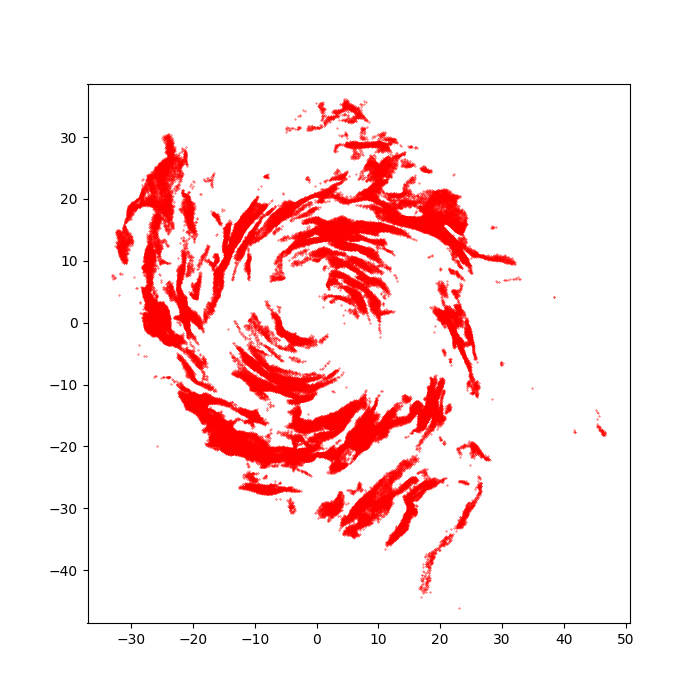

In [85]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(Xs,Ys,s=0.1,alpha=1, c ='red')
plt.axis('equal')


In [86]:
%matplotlib widget

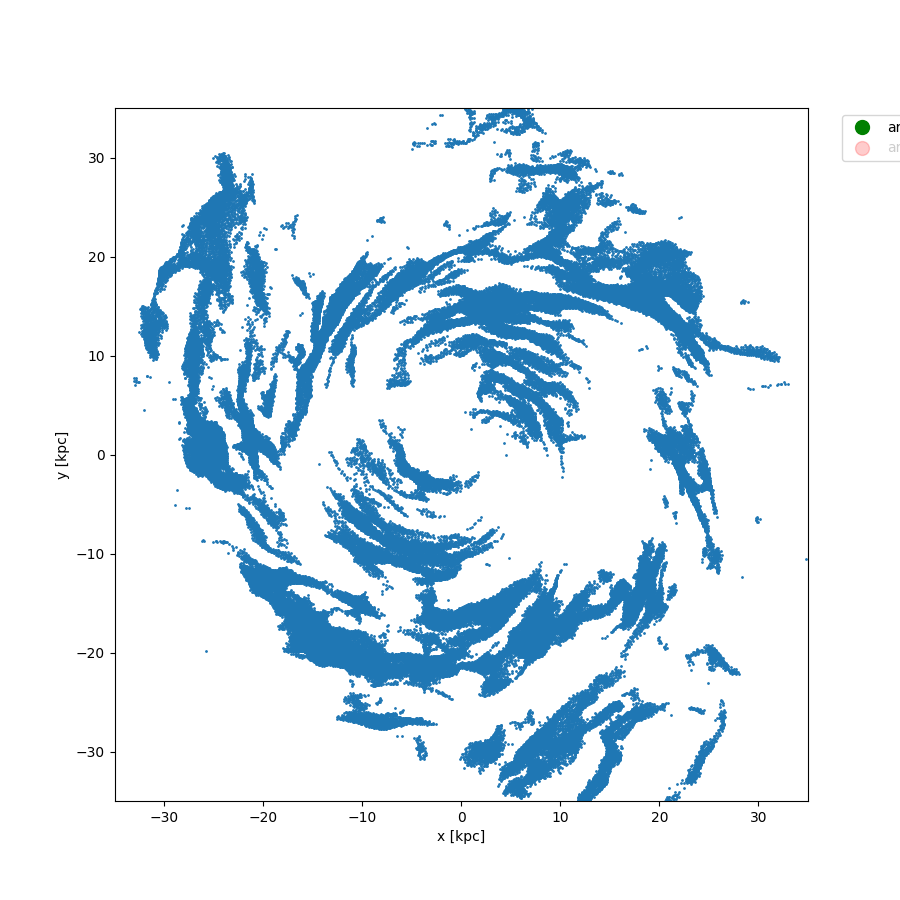

In [89]:
fig, ax = plt.subplots(figsize=(9,9))
ax.scatter(Xs,Ys,s=1,alpha=1)
R = 35
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)

#ax.scatter(x_trace_arm1_rho,y_trace_arm1_rho,color='red',s=200,marker='*')

#for i in range(len(nums1_rho)):
#    ax.annotate(nums1_rho[i], (x_trace_arm1_rho[i], y_trace_arm1_rho[i]),fontsize=15)
klicker = clicker(ax, ["arm1",'arm2'], markers=["o","o"], colors = ['green','red'], markersize = 10)
ax.set_xlabel(r'x [kpc]')
ax.set_ylabel(r'y [kpc]')
ax.set_aspect('equal')

In [90]:
dict_pos = klicker.get_positions()
arm1 = pd.DataFrame({'x':dict_pos['arm1'][:,0],'y':dict_pos['arm1'][:,1]})
arm2 = pd.DataFrame({'x':dict_pos['arm2'][:,0],'y':dict_pos['arm2'][:,1]})

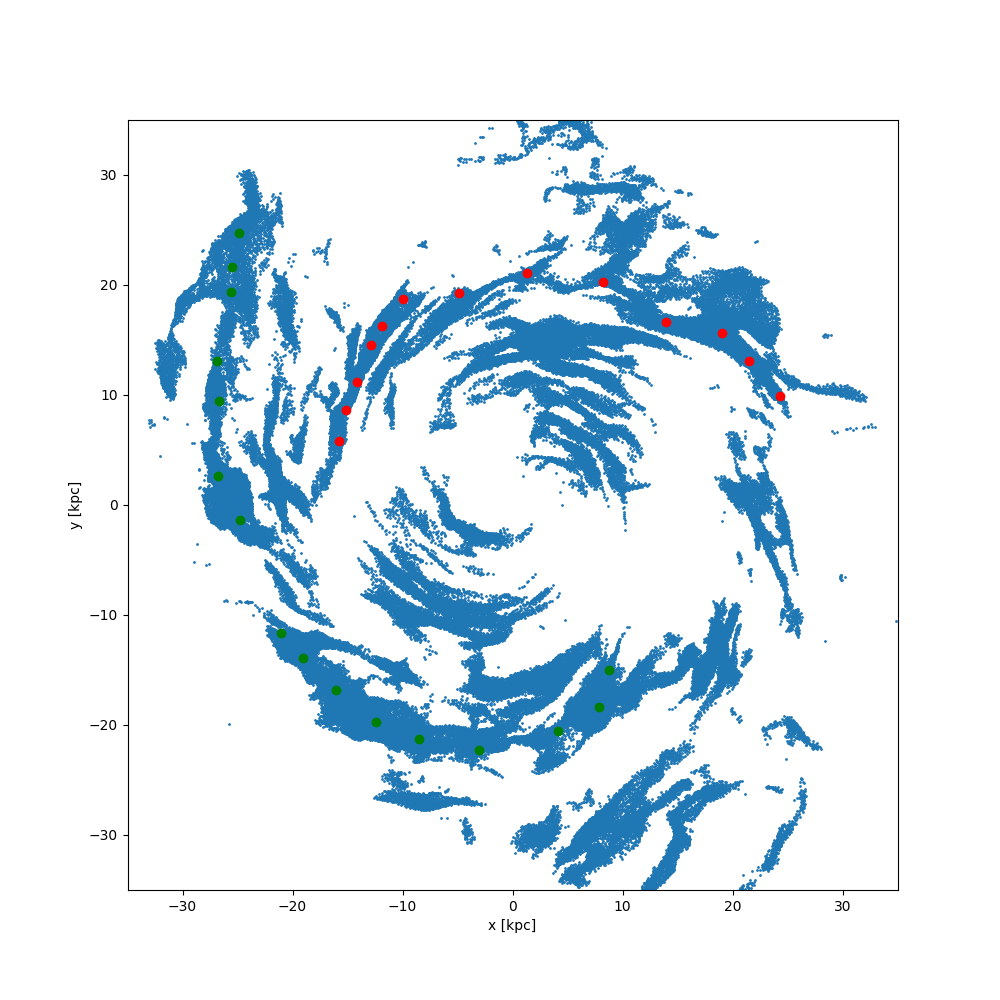

In [92]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(Xs,Ys,s=1,alpha=1)
ax.scatter(arm1.x, arm1.y, color = 'green')
ax.scatter(arm2.x, arm2.y, color = 'red')

R = 35
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_xlabel(r'x [kpc]')
ax.set_ylabel(r'y [kpc]')
ax.set_aspect('equal')

In [93]:
arm1.to_csv(f'DATA/processed/TracingPoints/arm_tracing_{id}_arm1_rho_dani.csv', index = False)
arm2.to_csv(f'DATA/processed/TracingPoints/arm_tracing_{id}_arm2_rho_dani.csv', index = False)